In [179]:
%matplotlib notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import math
import numpy as np
from sklearn import tree
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import roc_auc_score
import pickle

In [84]:
df = pd.read_csv("train.csv")
print(df.head(15))

    PassengerId  Survived  Pclass  \
0             1         0       3   
1             2         1       1   
2             3         1       3   
3             4         1       1   
4             5         0       3   
5             6         0       3   
6             7         0       1   
7             8         0       3   
8             9         1       3   
9            10         1       2   
10           11         1       3   
11           12         1       1   
12           13         0       3   
13           14         0       3   
14           15         0       3   

                                                 Name     Sex   Age  SibSp  \
0                             Braund, Mr. Owen Harris    male  22.0      1   
1   Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                              Heikkinen, Miss. Laina  female  26.0      0   
3        Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                

In [85]:
print(df.describe())

       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200  


In [86]:
df['modified_name'] = df['Name'].str.replace('.','|')
df['modified_name'] = df['modified_name'].str.replace(',','|')
print(df['modified_name'].head(10))

0                              Braund| Mr| Owen Harris
1    Cumings| Mrs| John Bradley (Florence Briggs Th...
2                               Heikkinen| Miss| Laina
3         Futrelle| Mrs| Jacques Heath (Lily May Peel)
4                             Allen| Mr| William Henry
5                                     Moran| Mr| James
6                              McCarthy| Mr| Timothy J
7                       Palsson| Master| Gosta Leonard
8    Johnson| Mrs| Oscar W (Elisabeth Vilhelmina Berg)
9                  Nasser| Mrs| Nicholas (Adele Achem)
Name: modified_name, dtype: object


In [87]:
df['Surname'] = df['modified_name'].str.split('|').str.get(0).str.strip()
df['title'] = df['modified_name'].str.split('|').str.get(1).str.strip()
print(df['title'].head(10))

0        Mr
1       Mrs
2      Miss
3       Mrs
4        Mr
5        Mr
6        Mr
7    Master
8       Mrs
9       Mrs
Name: title, dtype: object


In [88]:
#Get the mean age for each title
title_age_df = df[['title', 'Age']].copy()

In [89]:
#Change Mlle and Ms to Miss
mask = ((title_age_df['title'] == 'Mlle')|
        (title_age_df['title'] == 'Ms'))
title_age_df.loc[mask,'title'] = 'Miss'
df.loc[mask,'title'] = 'Miss'

#Change Mme to Mrs
mask = (title_age_df['title'] == 'Mme')
title_age_df.loc[mask,'title'] = 'Mrs' 
df.loc[mask,'title'] = 'Mrs'

#Replace other than Mr, Master, Mrs, and Miss to others
mask = ~((title_age_df['title'] == 'Mr') |
        (title_age_df['title'] == 'Miss') |
        (title_age_df['title'] == 'Master') |
        (title_age_df['title'] == 'Mrs'))

title_age_df.loc[mask,'title'] = 'others'          
df.loc[mask, 'title'] = 'others'                   

print(title_age_df.head(10))

    title   Age
0      Mr  22.0
1     Mrs  38.0
2    Miss  26.0
3     Mrs  35.0
4      Mr  35.0
5      Mr   NaN
6      Mr  54.0
7  Master   2.0
8     Mrs  27.0
9     Mrs  14.0


In [90]:
title_age_df.columns = ['title','prediction_age']
title_age_df = title_age_df.groupby('title').mean()

In [91]:
print(title_age_df.head(10))

        prediction_age
title                 
Master        4.574167
Miss         21.845638
Mr           32.368090
Mrs          35.788991
others       45.545455


In [92]:
#Create fillna table to help filling NA values
fillna_table = df.copy()
fillna_table = fillna_table.join(title_age_df, on = 'title')
fillna_table['Age'] = fillna_table['prediction_age']

print(fillna_table.head(10))

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   
5            6         0       3   
6            7         0       1   
7            8         0       3   
8            9         1       3   
9           10         1       2   

                                                Name     Sex        Age  \
0                            Braund, Mr. Owen Harris    male  32.368090   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  35.788991   
2                             Heikkinen, Miss. Laina  female  21.845638   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.788991   
4                           Allen, Mr. William Henry    male  32.368090   
5                                   Moran, Mr. James    male  32.368090   
6                            McCarthy, Mr. Timothy J    male  32.368090   
7  

In [93]:
#Use age in fillna table to fill missing values in df
df = df.fillna(fillna_table)
print(df.head(5))

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  \
0      0         A/5 21171   7.2500   NaN        S   
1      0          PC 17599  71.2833   C85        C   
2      0  STON/O2. 3101282   7.9250   NaN        S   
3      0            113803  53.1000  C123        S   
4      0            373450   8.0500   NaN        S

In [94]:
#Number of relatives = SibSp + Parch
df['NumRelatives'] = df['SibSp'] + df['Parch'] + 1

In [95]:
temp_df = df[['Survived','NumRelatives']].copy()
fam = temp_df.groupby('NumRelatives').mean()
print(fam)

              Survived
NumRelatives          
1             0.303538
2             0.552795
3             0.578431
4             0.724138
5             0.200000
6             0.136364
7             0.333333
8             0.000000
11            0.000000


<IPython.core.display.Javascript object>


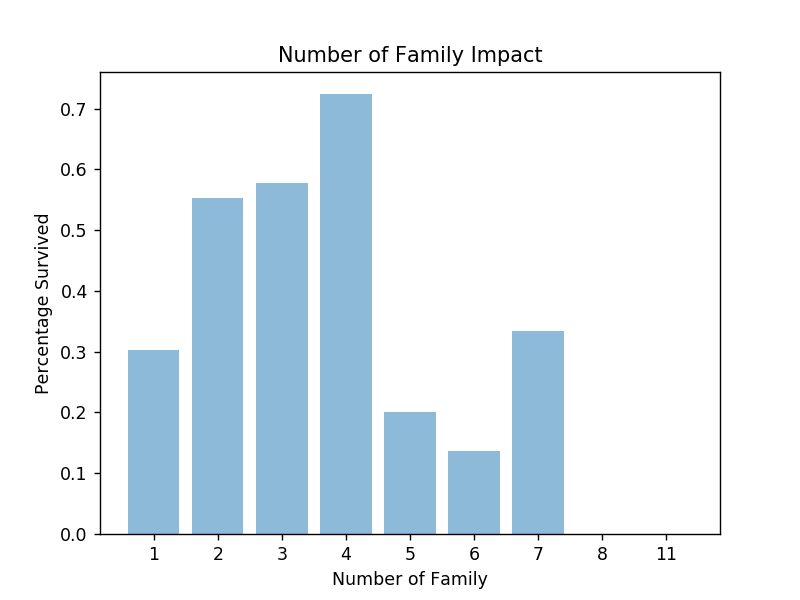

In [125]:
objects = fam.index
y_pos = np.arange(len(objects))
performance = fam['Survived']
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Percentage Survived')
plt.xlabel('Number of Family')
plt.title('Number of Family Impact')
 
plt.show()

In [97]:
print(df.corr())

              PassengerId  Survived    Pclass       Age     SibSp     Parch  \
PassengerId      1.000000 -0.005007 -0.035144  0.042972 -0.057527 -0.001652   
Survived        -0.005007  1.000000 -0.338481 -0.089402 -0.035322  0.081629   
Pclass          -0.035144 -0.338481  1.000000 -0.343799  0.083081  0.018443   
Age              0.042972 -0.089402 -0.343799  1.000000 -0.267659 -0.196902   
SibSp           -0.057527 -0.035322  0.083081 -0.267659  1.000000  0.414838   
Parch           -0.001652  0.081629  0.018443 -0.196902  0.414838  1.000000   
Fare             0.012658  0.257307 -0.549500  0.091029  0.159651  0.216225   
NumRelatives    -0.040143  0.016639  0.065997 -0.281305  0.890712  0.783111   

                  Fare  NumRelatives  
PassengerId   0.012658     -0.040143  
Survived      0.257307      0.016639  
Pclass       -0.549500      0.065997  
Age           0.091029     -0.281305  
SibSp         0.159651      0.890712  
Parch         0.216225      0.783111  
Fare          1

In [98]:
def extract_string(s) :
    if isinstance(s,float):     
        if math.isnan(s):
            return "-"
    tmp = str(s)
    return tmp[0]

In [99]:
df['cabin_code'] = df["Cabin"].apply(extract_string)
print(df[["cabin_code", "Cabin"]].head(20))

   cabin_code Cabin
0           -   NaN
1           C   C85
2           -   NaN
3           C  C123
4           -   NaN
5           -   NaN
6           E   E46
7           -   NaN
8           -   NaN
9           -   NaN
10          G    G6
11          C  C103
12          -   NaN
13          -   NaN
14          -   NaN
15          -   NaN
16          -   NaN
17          -   NaN
18          -   NaN
19          -   NaN


In [114]:
tempdf = df[["cabin_code","Survived"]]
tempdf = tempdf.groupby("cabin_code").mean()
print(tempdf.head(10))

            Survived
cabin_code          
-           0.299854
A           0.466667
B           0.744681
C           0.593220
D           0.757576
E           0.750000
F           0.615385
G           0.500000
T           0.000000


<IPython.core.display.Javascript object>


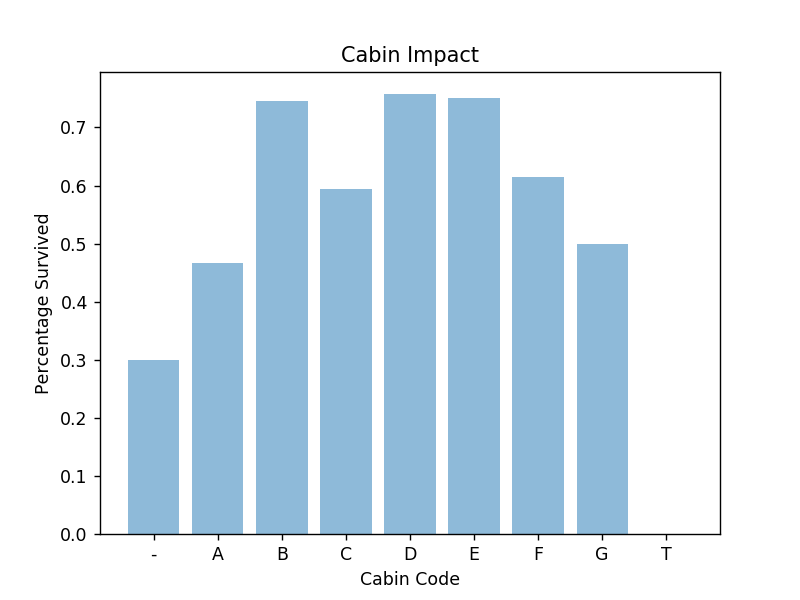

In [127]:
objects = tempdf.index
y_pos = np.arange(len(objects))
performance = tempdf['Survived']
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Percentage Survived')
plt.xlabel('Cabin Code')
plt.title('Cabin Impact')
 
plt.show()

In [102]:
def describe_categorical(X):
    from IPython.display import display, HTML
    display(HTML(X[X.columns[X.dtypes == "object"]].describe().to_html()))

In [103]:
describe_categorical(df)

,Name,Sex,Ticket,Cabin,Embarked,modified_name,Surname,title,cabin_code
count,891,891,891,204,889,891,891,891,891
unique,891,2,681,147,3,891,667,5,9
top,"Pavlovic, Mr. Stefo",male,347082,C23 C25 C27,S,Meyer| Mr| August,Andersson,Mr,-
freq,1,577,7,4,644,1,9,517,687


In [104]:
def transform_string(s) :
    if isinstance(s,float):     
        if math.isnan(s):
            return "-"
    tmp = str(s)
    return tmp

In [117]:
temp1df = df[["Pclass","cabin_code"]]

temp1df["combination"] = temp1df["Pclass"].map(str) + temp1df["cabin_code"]
temp1df.drop(temp1df[temp1df["cabin_code"] == "-"].index,inplace = True)
print(temp1df.head(10))

    Pclass cabin_code combination
1        1          C          1C
3        1          C          1C
6        1          E          1E
10       3          G          3G
11       1          C          1C
21       2          D          2D
23       1          A          1A
27       1          C          1C
31       1          B          1B
52       1          D          1D


c:\python34\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
c:\python34\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [118]:
temp1df = temp1df.groupby("combination").count()
print(temp1df.head(20))

             Pclass  cabin_code
combination                    
1A               15          15
1B               47          47
1C               59          59
1D               29          29
1E               25          25
1T                1           1
2D                4           4
2E                4           4
2F                8           8
3E                3           3
3F                5           5
3G                4           4


<IPython.core.display.Javascript object>


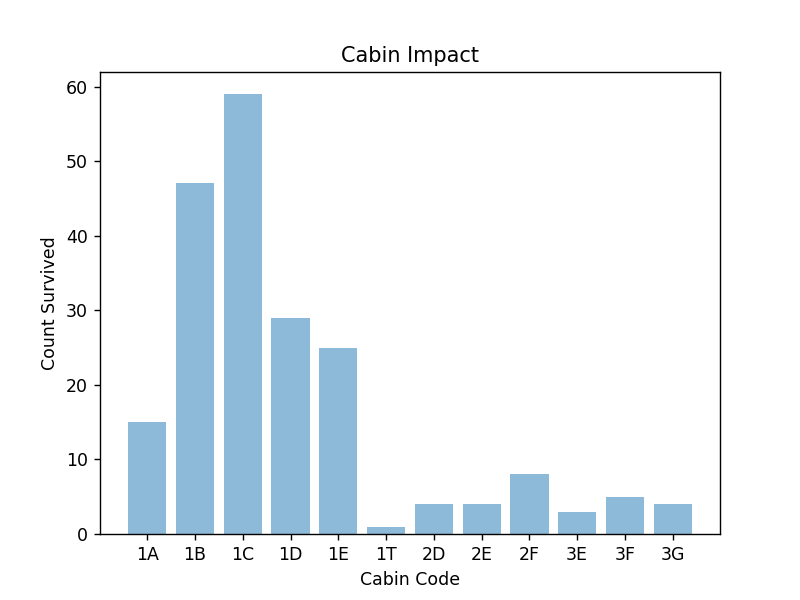

In [129]:
objects = temp1df.index
y_pos = np.arange(len(objects))
performance = temp1df['Pclass']
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Count Survived')
plt.xlabel('Cabin Code')
plt.title('Cabin Impact')
 
plt.show()

Kesimpulan : Tidak perlu menggunakan kabin

In [130]:
print(df.head(5))

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  \
0      0         A/5 21171   7.2500   NaN        S   
1      0          PC 17599  71.2833   C85        C   
2      0  STON/O2. 3101282   7.9250   NaN        S   
3      0            113803  53.1000  C123        S   
4      0            373450   8.0500   NaN        S

In [131]:
df.drop("cabin_code",axis = 1,inplace = True)
df.drop("Cabin",axis = 1,inplace = True)
df.drop("modified_name",axis = 1,inplace = True)
df.drop("PassengerId",axis = 1,inplace = True)
df.drop("Name",axis = 1,inplace = True)
df.drop("Surname",axis = 1,inplace = True)
df.drop("title",axis = 1,inplace = True)
df.drop("SibSp",axis = 1,inplace = True)
df.drop("Parch",axis = 1,inplace = True)
df.drop("Ticket",axis = 1,inplace = True)

In [132]:
print(df.head(5))

   Survived  Pclass     Sex   Age     Fare Embarked  NumRelatives
0         0       3    male  22.0   7.2500        S             2
1         1       1  female  38.0  71.2833        C             2
2         1       3  female  26.0   7.9250        S             1
3         1       1  female  35.0  53.1000        S             2
4         0       3    male  35.0   8.0500        S             1


In [137]:
dummies = pd.get_dummies(df["Embarked"], prefix = "Embarked")
df = pd.concat([df, dummies], axis = 1)
df.drop("Embarked",axis = 1, inplace = True)

In [138]:
print(df.head(5))

   Survived  Pclass     Sex   Age     Fare  NumRelatives  Embarked_C  \
0         0       3    male  22.0   7.2500             2           0   
1         1       1  female  38.0  71.2833             2           1   
2         1       3  female  26.0   7.9250             1           0   
3         1       1  female  35.0  53.1000             2           0   
4         0       3    male  35.0   8.0500             1           0   

   Embarked_Q  Embarked_S  Embarked_C  Embarked_Q  Embarked_S  
0           0           1           0           0           1  
1           0           0           1           0           0  
2           0           1           0           0           1  
3           0           1           0           0           1  
4           0           1           0           0           1  


In [139]:
dummies = pd.get_dummies(df["Sex"],prefix = "Is")
df = pd.concat([df, dummies], axis = 1)
df.drop("Sex",axis = 1, inplace = True)

In [140]:
print(df.head(5))

   Survived  Pclass   Age     Fare  NumRelatives  Embarked_C  Embarked_Q  \
0         0       3  22.0   7.2500             2           0           0   
1         1       1  38.0  71.2833             2           1           0   
2         1       3  26.0   7.9250             1           0           0   
3         1       1  35.0  53.1000             2           0           0   
4         0       3  35.0   8.0500             1           0           0   

   Embarked_S  Embarked_C  Embarked_Q  Embarked_S  Is_female  Is_male  
0           1           0           0           1          0        1  
1           0           1           0           0          1        0  
2           1           0           0           1          1        0  
3           1           0           0           1          1        0  
4           1           0           0           1          0        1  


In [172]:
x = df.drop("Survived", axis = 1)
y = df["Survived"]

In [173]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(x, y)
print("Accuracy Store " + str(clf.score(x,y)))

Accuracy Store 0.982042648709


In [174]:
cv = cross_val_score(clf, x, y, cv = 10)
print(cv)

[ 0.74444444  0.77777778  0.73033708  0.76404494  0.82022472  0.7752809
  0.83146067  0.73033708  0.78651685  0.875     ]


<IPython.core.display.Javascript object>


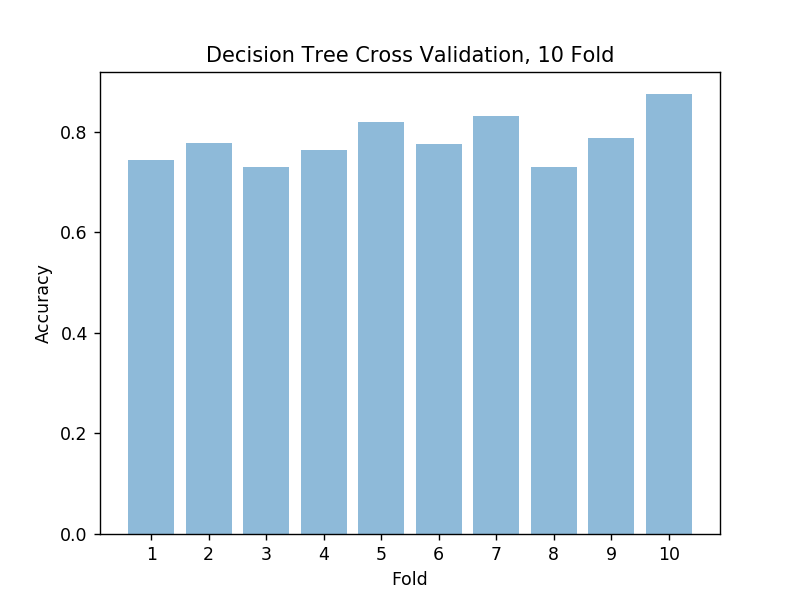

In [175]:
objects = (1, 2, 3, 4, 5, 6, 7, 8, 9, 10)
y_pos = np.arange(len(objects))
performance = cv
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy')
plt.xlabel('Fold')
plt.title('Decision Tree Cross Validation, 10 Fold')
 
plt.show()

# decision tree result

In [176]:
cva = np.array(cv)
mean = np.mean(cva)
std = np.std(cva)
print("Mean: " + str(mean))
print("Standard Deviation: " + str(std))

Mean: 0.783542446941
Standard Deviation: 0.0443700238254


In [177]:
model = RandomForestRegressor(100, oob_score = True, n_jobs = 1 , random_state = 200)
model.fit(x, y)
print ("C-stat: " + str(roc_auc_score(y, model.oob_prediction_)))

C-stat: 0.862666304498


In [180]:
# Store object to pickle
with open('tree.pickle', 'wb') as handle:
    pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)